<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/002_TensorFlow_Proj_Two_CNN_TransferLearning_DogsVsCats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Utils

In [1]:
# utils
import glob, shutil, os, sys, itertools, warnings, platform
import itertools
import pandas as pd
import numpy as np
from random import (randint, sample, choice)
# display
from IPython.display import Image
# google
from google.colab import drive
# sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import (Sequential, Model, load_model)
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                     Flatten, Dense, Activation,
                                     AveragePooling2D, Dropout, Rescaling,
                                     Reshape, BatchNormalization, ZeroPadding2D,
                                     MaxPool2D, add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.config import list_physical_devices
from tensorflow.keras.metrics import (CategoricalCrossentropy,
                                      SparseCategoricalCrossentropy,
                                      categorical_crossentropy,
                                      binary_crossentropy)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                  load_img,
                                                  img_to_array)
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.datasets import cifar10
# matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

In [2]:
print("tensorflow version: ", tf.__version__)

tensorflow version:  2.17.0


### Settings

In [3]:
# setup gpu
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices("GPU")
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth set for device:", physical_devices[0])
    except Exception as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

GPU memory growth set for device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
print("Python platform: {}".format(platform.platform()))

Python platform: Linux-6.1.85+-x86_64-with-glibc2.35


In [5]:
print("Python: {}".format(sys.version))

Python: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [6]:
warnings.filterwarnings("ignore")

In [7]:
# mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


## Funcs

In [52]:
def plot_training_results(monitor, x_test, y_test, n_samples=10):
    """
    Plot training and validation loss and accuracy, confusion matrix, and sample predictions.

    Parameters:
    - monitor: The history object returned by model.fit().
    - x_test: Test data for evaluation.
    - y_test: True labels for test data.
    - n_samples: Number of samples to show in the predictions plot.
    """

    # plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(monitor.history['loss'], '-o', label='Training Loss')
    plt.plot(monitor.history['val_loss'], '-o', label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(monitor.history['accuracy'], '-o', label='Training Accuracy')
    plt.plot(monitor.history['val_accuracy'], '-o', label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # confusion Matrix
    y_pred = np.argmax(model.predict(x_test), axis=1)
    conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.arange(num_labels), yticklabels=np.arange(num_labels))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # sample Predictions
    sample_indices = np.random.choice(len(x_test), n_samples, replace=False)
    sample_images = x_test[sample_indices]
    sample_true_labels = np.argmax(y_test[sample_indices], axis=1)
    sample_pred_labels = y_pred[sample_indices]

    plt.figure(figsize=(8, 6))
    for i in range(n_samples):
        plt.subplot(3, 4, i + 1)
        plt.imshow(sample_images[i])
        plt.title(f'True: {sample_true_labels[i]}, Pred: {sample_pred_labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Model - Conv2D

### Load Data

In [8]:
os.getcwd()

'/content'

In [9]:
os.chdir("/content/drive/MyDrive/DataSets/dogs-vs-cats/")

In [10]:
train_path = "train"
valid_path = "valid"
test_path = "test"

In [11]:
# train
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    ).flow_from_directory(
    directory=train_path, target_size=(224, 224),
    classes=["cat", "dog"], batch_size=10
    )
# valid
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    ).flow_from_directory(
    directory=valid_path, target_size=(224, 224),
    classes=["cat", "dog"], batch_size=10
    )
# test
test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    ).flow_from_directory(
    directory=test_path, target_size=(224, 224),
    classes=["cat", "dog"], batch_size=10, shuffle=False
    )

assert train_batches.n == 996
assert valid_batches.n == 200
assert test_batches.n == 200

Found 996 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [12]:
# attributes
attrs = [attr for attr in dir(train_batches) if not attr.startswith("_") and not callable(getattr(train_batches, attr))]
for attr in attrs:
    print(f"Attribute: {attr}")

Attribute: allowed_class_modes
Attribute: batch_index
Attribute: batch_size
Attribute: class_indices
Attribute: class_mode
Attribute: classes
Attribute: color_mode
Attribute: data_format
Attribute: directory
Attribute: dtype
Attribute: filenames
Attribute: filepaths
Attribute: image_data_generator
Attribute: image_shape
Attribute: index_array
Attribute: index_generator
Attribute: interpolation
Attribute: keep_aspect_ratio
Attribute: labels
Attribute: lock
Attribute: max_queue_size
Attribute: n
Attribute: num_batches
Attribute: num_classes
Attribute: sample_weight
Attribute: samples
Attribute: save_format
Attribute: save_prefix
Attribute: save_to_dir
Attribute: seed
Attribute: shuffle
Attribute: split
Attribute: subset
Attribute: target_size
Attribute: total_batches_seen
Attribute: use_multiprocessing
Attribute: white_list_formats
Attribute: workers


In [13]:
# methods
methods = [met for met in dir(train_batches) if not met.startswith("_") and callable(getattr(train_batches, met))]
for method in methods:
    print(f"Methods: {method}")

Methods: on_epoch_end
Methods: reset
Methods: set_processing_attrs


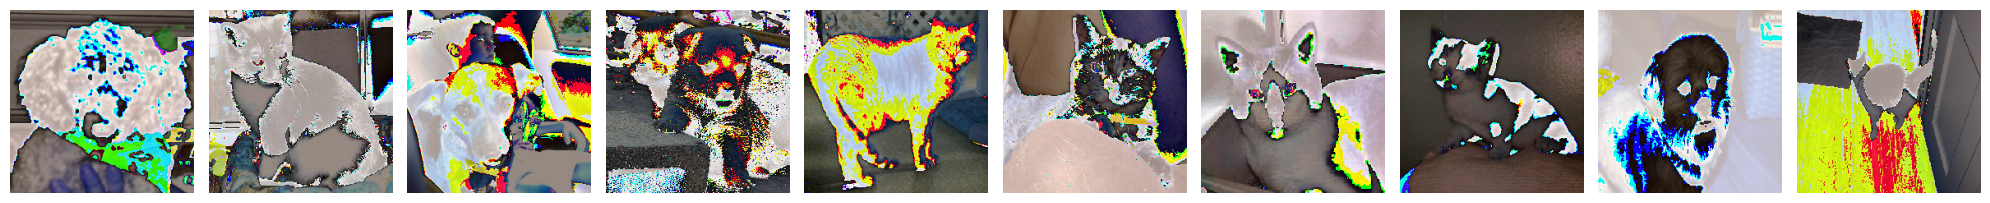

labels
 [[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [14]:
imgs, labels = next(train_batches)
def plot_images(img_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(img_arr, axes):
    ax.imshow(img.astype('uint8'))
    ax.axis("off")
  plt.tight_layout()
  plt.show()
plot_images(imgs)
print("labels\n", labels)

### Develop Model

In [15]:
%%time
model = Sequential(
    [
        Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same", input_shape=(224, 224,3)),
        MaxPool2D(pool_size=(2,2), strides=2),
        Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"),
        MaxPool2D(pool_size=(2,2), strides=2),
        Flatten(),
        Dense(units=2, activation="softmax")
    ]
    )
model.summary()
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │         401,410 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420,802 (1.61 MB)

 Trainable params: 420,802 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 - 248s - 2s/step - accuracy: 0.5271 - loss: 13.9955 - val_accuracy: 0.6150 - val_loss: 4.4137
Epoch 2/10
100/100 - 6s - 58ms/step - accuracy: 0.7460 - loss: 2.2424 - val_accuracy: 0.6750 - val_loss: 2.5206
Epoch 3/10
100/100 - 10s - 105ms/step - accuracy: 0.9076 - loss: 0.4066 - val_accuracy: 0.6450 - val_loss: 2.2101
Epoch 4/10
100/100 - 7s - 67ms/step - accuracy: 0.9759 - loss: 0.0673 - val_accuracy: 0.6200 - val_loss: 1.9680
Epoch 5/10
100/100 - 9s - 95ms/step - accuracy: 0.9759 - loss: 0.0742 - val_accuracy: 0.6400 - val_loss: 2.1668
Epoch 6/10
100/100 - 10s - 100ms/step - accuracy: 0.9960 - loss: 0.0194 - val_accuracy: 0.6450 - val_loss: 1.8378
Epoch 7/10
100/100 - 7s - 67ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.6600 - val_loss: 1.8081
Epoch 8/10
100/100 - 6s - 58ms/step - accuracy: 1.0000 - loss: 8.8374e-04 - val_accuracy: 0.6500 - val_loss: 1.8126
Epoch 9/10
100/100 - 11s - 110ms/step - accuracy: 1.0000 - loss: 7.2976e-04 - val_accuracy: 0.6

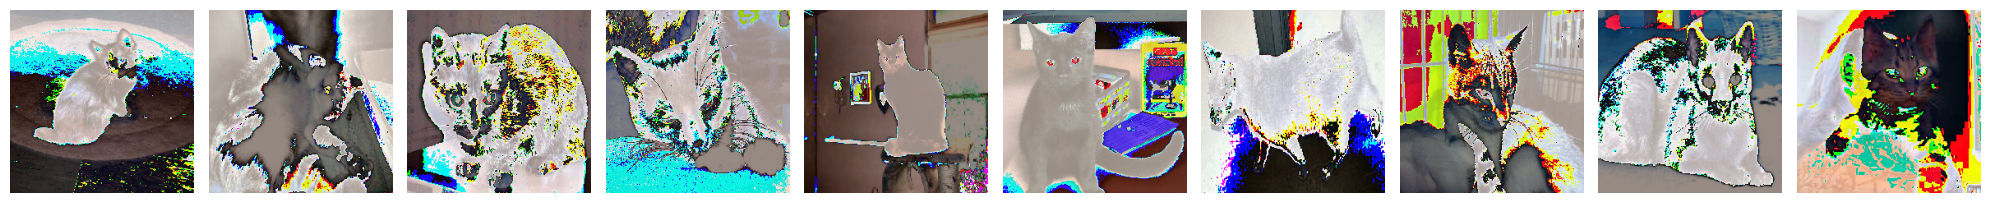

labels
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [16]:
test_imgs, test_labels = next(test_batches)
plot_images(test_imgs)
print("labels\n", test_labels)

In [17]:
# prediction
pred = model.predict(x=test_batches, verbose=0)

In [18]:
# confusion matrix
def plot_conf_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype("float")/ cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix no normalization")
  print(cm)
  thresh = cm.max()/2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

Confusion matrix no normalization
[[65 35]
 [35 65]]


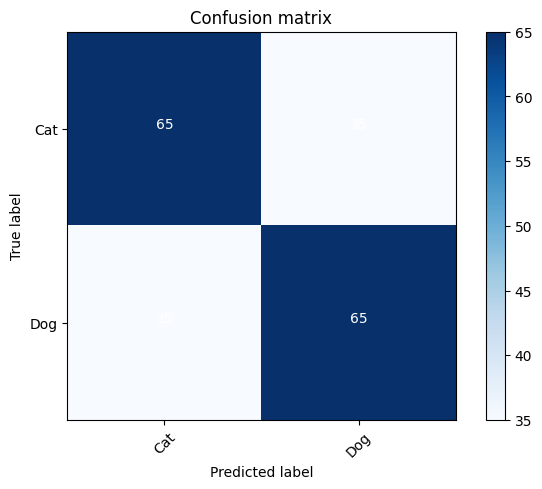

In [19]:
# plot
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(pred, axis=-1))
cm_plot_labels = ["Cat", "Dog"]
plot_conf_matrix(cm=cm, classes=cm_plot_labels)

In [20]:
for layer in model.layers:
  print(layer.name, layer.trainable)

conv2d True
max_pooling2d True
conv2d_1 True
max_pooling2d_1 True
flatten True
dense True


In [21]:
layer_outputs = [layer.output for layer in model.layers if 'conv2d' in layer.name]
activation_model = Model(inputs=model.inputs, outputs=layer_outputs)
activation_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,392 (75.75 KB)

 Trainable params: 19,392 (75.75 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
Layer: conv2d, Number of filters: 32, Size: 224


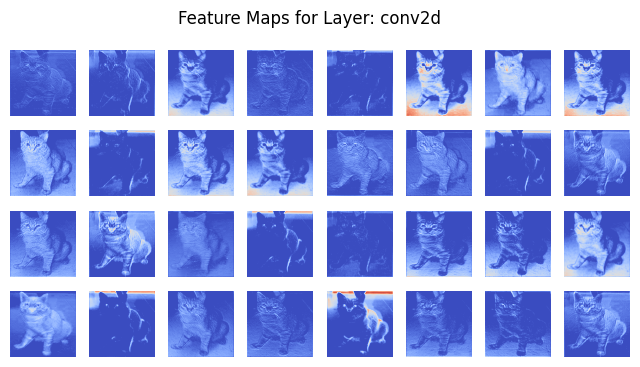

Layer: conv2d_1, Number of filters: 64, Size: 112


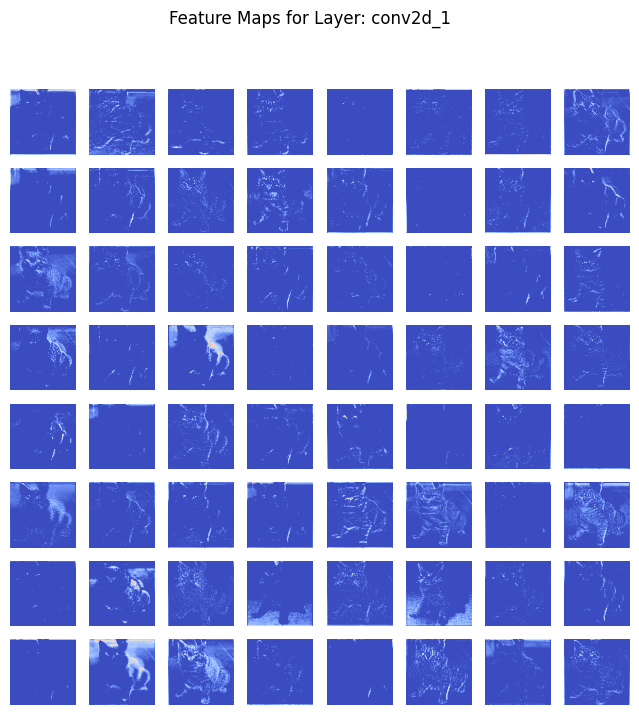

In [22]:
def plot_feature_maps_from_batch(test_batches, model):

    image_batch, label_batch = next(test_batches)
    img_array = image_batch[0:1]

    feature_maps = model.predict(img_array)

    for layer_name, feature_map in zip([layer.name for layer in model.layers if 'conv2d' in layer.name], feature_maps):
        num_filters = feature_map.shape[-1]
        size = feature_map.shape[1]

        print(f"Layer: {layer_name}, Number of filters: {num_filters}, Size: {size}")

        n_cols = 8
        n_rows = num_filters // n_cols

        fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
        fig.suptitle(f'Feature Maps for Layer: {layer_name}')
        for i in range(num_filters):
            ax[i // n_cols, i % n_cols].imshow(feature_map[0, :, :, i], cmap='coolwarm')
            ax[i // n_cols, i % n_cols].axis('off')
        plt.show()

plot_feature_maps_from_batch(test_batches, activation_model)

## Transfer Learning - VGG16

In [23]:
vgg16_model = tf.keras.applications.vgg16.VGG16()
vgg16_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
def count_params(model):
  non_trainable_params = np.sum([np.prod(_.shape.as_list()) for _ in model.non_trainable_weights])
  trainable_params = np.sum([np.prod(_.shape.as_list()) for _ in model.trainable_weights])
  return {"non_trainable_params": non_trainable_params, "trainable_params": trainable_params}

In [25]:
params = count_params(vgg16_model)
assert params["non_trainable_params"] == 0
assert params["trainable_params"] == 138357544
print(params)

{'non_trainable_params': 0.0, 'trainable_params': 138357544}


In [26]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 4096)                │      16,781,312 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
for layer in model.layers:
  layer.trainable = False

model.add(Dense(units=2, activation="softmax"))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [28]:
params = count_params(model)
assert params["non_trainable_params"] == 134260544
assert params["trainable_params"] == 8194

In [29]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
100/100 - 21s - 206ms/step - accuracy: 0.9096 - loss: 0.2130 - val_accuracy: 0.9650 - val_loss: 0.0959
Epoch 2/10
100/100 - 8s - 80ms/step - accuracy: 0.9759 - loss: 0.0636 - val_accuracy: 0.9700 - val_loss: 0.0747
Epoch 3/10
100/100 - 8s - 81ms/step - accuracy: 0.9880 - loss: 0.0402 - val_accuracy: 0.9800 - val_loss: 0.0702
Epoch 4/10
100/100 - 7s - 70ms/step - accuracy: 0.9930 - loss: 0.0280 - val_accuracy: 0.9700 - val_loss: 0.0659
Epoch 5/10
100/100 - 8s - 80ms/step - accuracy: 0.9960 - loss: 0.0188 - val_accuracy: 0.9700 - val_loss: 0.0634
Epoch 6/10
100/100 - 11s - 111ms/step - accuracy: 0.9990 - loss: 0.0145 - val_accuracy: 0.9750 - val_loss: 0.0620
Epoch 7/10
100/100 - 8s - 84ms/step - accuracy: 0.9990 - loss: 0.0112 - val_accuracy: 0.9750 - val_loss: 0.0592
Epoch 8/10
100/100 - 10s - 102ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.9800 - val_loss: 0.0587
Epoch 9/10
100/100 - 11s - 113ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.9800 - v

Confusion matrix no normalization
[[95  5]
 [ 3 97]]


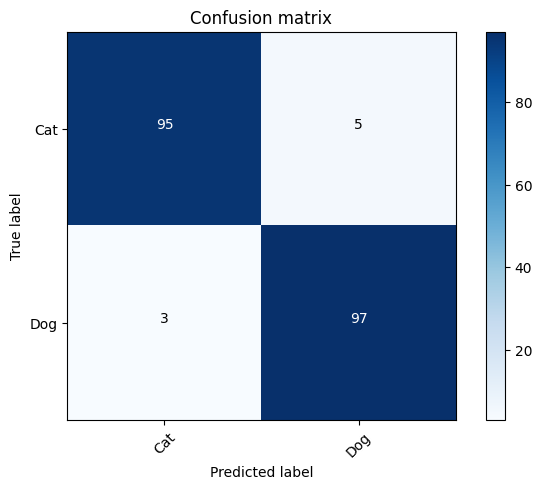

In [30]:
pred = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(pred, axis=-1))
cm_plot_labels = ["Cat", "Dog"]
plot_conf_matrix(cm=cm, classes=cm_plot_labels)

## Tranfer Learning - MobileNet

In [31]:
os.chdir("../animals/")

In [32]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
def prep_image(file):
  img_path = "./"
  img = image.load_img(img_path + file, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array_expanded_dims = np.expand_dims(img_array, axis=0)
  return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

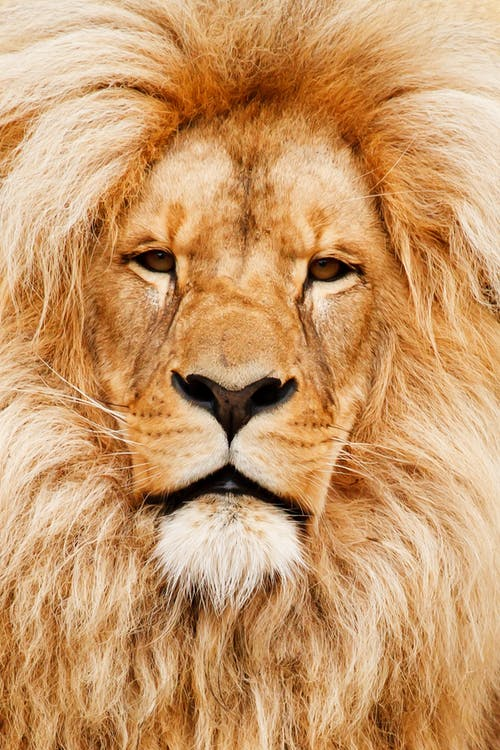

In [34]:
Image(filename="africa-african-animal-cat-41315.jpeg", width=200, height=200)

In [35]:
preprocessed_image = prep_image("africa-african-animal-cat-41315.jpeg")
pred = mobile.predict(preprocessed_image)
result = imagenet_utils.decode_predictions(pred)
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[[('n02129165', 'lion', 0.9967367),
  ('n02112137', 'chow', 0.003008327),
  ('n02086079', 'Pekinese', 9.338353e-05),
  ('n02108551', 'Tibetan_mastiff', 8.2110215e-05),
  ('n02097474', 'Tibetan_terrier', 2.0593925e-05)]]

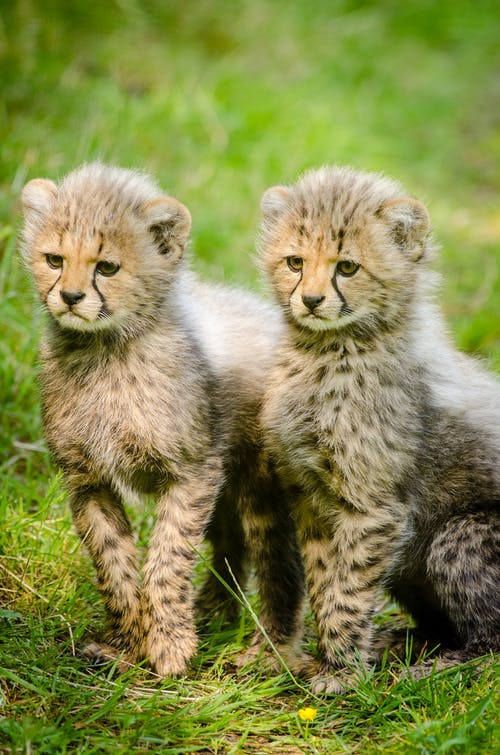

In [36]:
Image(filename="cheetahs-cubs-two-together-162318.jpeg", width=200, height=200)

In [37]:
preprocessed_image = prep_image("cheetahs-cubs-two-together-162318.jpeg")
pred = mobile.predict(preprocessed_image)
result = imagenet_utils.decode_predictions(pred)
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[[('n02130308', 'cheetah', 0.5283734),
  ('n02127052', 'lynx', 0.41354966),
  ('n02119789', 'kit_fox', 0.017139178),
  ('n02124075', 'Egyptian_cat', 0.014206046),
  ('n02129165', 'lion', 0.00473807)]]

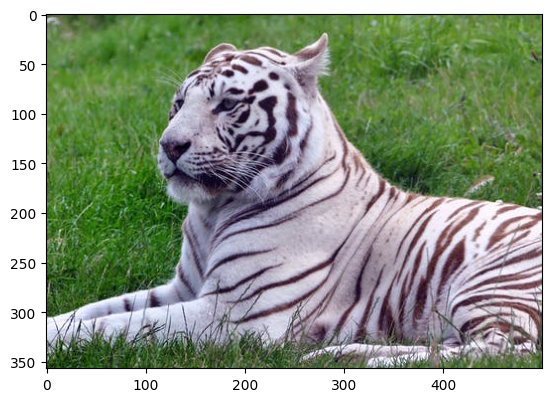

In [38]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15,
                         zoom_range=0.1, channel_shift_range=10., horizontal_flip=True)
img_path = choice(os.listdir("./"))
image = np.expand_dims(plt.imread(img_path), 0)
plt.imshow(image[0])

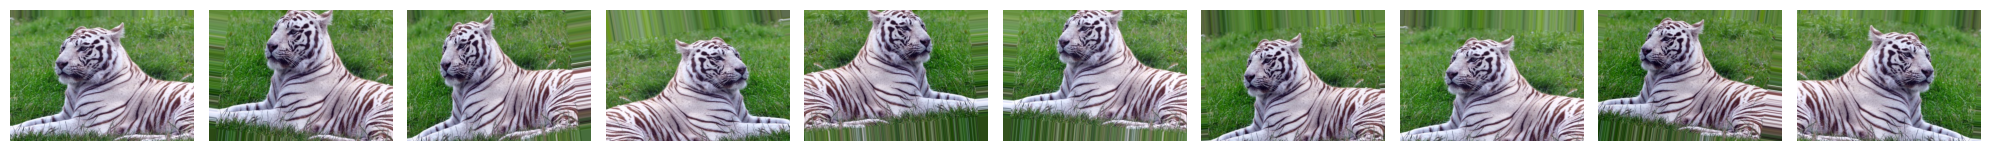

In [39]:
aug_iter = gen.flow(image)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
plot_images(aug_images)

# Resnet-Modification-CIFAR10

In [40]:
def identity_skip_block(inputs, kernel_size, filters, stage, block):

    shortcut_x = inputs
    f1, f2, f3 = filters
    bn_axis = 3
    x = Conv2D(f1, (1,1))(inputs)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)
    x = Conv2D(f2, kernel_size, padding="same")(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)
    x = Conv2D(f3, (1,1))(inputs)
    x = BatchNormalization(axis=bn_axis)(x)
    x = add([x, shortcut_x])
    x = Activation("relu")(x)
    return x

In [41]:
def conv_skip_block(inputs, kernel_size, filters, stage, block, strides=(1,1)):

    shortcut_x = inputs
    f1, f2, f3 = filters
    bn_axis = 3
    x = Conv2D(f1, (1,1), padding="same", strides=strides)(inputs)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)
    x = Conv2D(f2, kernel_size, padding="same")(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)
    x = Conv2D(f3, (1,1), padding="same")(inputs)
    x = BatchNormalization(axis=bn_axis)(x)
    shortcut_x = Conv2D(f3, (1,1), strides=strides)(shortcut_x)
    shortcut_x = BatchNormalization(axis=bn_axis)(shortcut_x)
    x = add([x, shortcut_x])
    x = Activation("relu")(x)
    return x

In [42]:
def ResNet50(input_shape, num_labels):

    img_input = Input(shape=input_shape)
    bn_axis = 3
    x = ZeroPadding2D((3,3))(img_input)
    x = Conv2D(64, (7,7), strides=(2,2), name="conv_one")(x)
    x = BatchNormalization(axis=bn_axis, name="bn_conv_one")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((3,3), strides=(2,2))(x)
    x = conv_skip_block(inputs=x, kernel_size=3, filters=[64,64,256], stage=2, block="a", strides=(1,1))
    x = identity_skip_block(inputs=x, kernel_size=3, filters=[64,64,256], stage=2, block="b")
    x = identity_skip_block(inputs=x, kernel_size=3, filters=[64,64,256], stage=2, block="c")

    x = conv_skip_block(inputs=x, kernel_size=3, filters=[128,128,512], stage=3, block="a")
    x = identity_skip_block(inputs=x, kernel_size=3, filters=[128,128,512], stage=3, block="b")
    x = identity_skip_block(inputs=x, kernel_size=3, filters=[128,128,512], stage=3, block="c")
    x = identity_skip_block(inputs=x, kernel_size=3, filters=[128,128,512], stage=3, block="d")

    x = conv_skip_block(inputs=x, kernel_size=3, filters=[256,256,1024], stage=4, block="a")
    x = identity_skip_block(inputs=x, kernel_size=3, filters=[256,256,1024], stage=4, block="b")
    x = identity_skip_block(inputs=x, kernel_size=3, filters=[256,256,1024], stage=4, block="c")
    x = identity_skip_block(inputs=x, kernel_size=3, filters=[256,256,1024], stage=4, block="d")
    x = identity_skip_block(inputs=x, kernel_size=3, filters=[256,256,1024], stage=4, block="e")
    x = identity_skip_block(inputs=x, kernel_size=3, filters=[256,256,1024], stage=4, block="f")

    x = conv_skip_block(inputs=x, kernel_size=3, filters=[512,512,2048], stage=5, block="a")
    x = identity_skip_block(inputs=x, kernel_size=3, filters=[512,512,2048], stage=5, block="b")
    x = identity_skip_block(inputs=x, kernel_size=3, filters=[512,512,2048], stage=5, block="c")
    x = AveragePooling2D((7,7), name="ave_pool")(x)
    x = Flatten()(x)
    outputs = Dense(num_labels, activation="softmax", name="fc10")(x)
    return img_input, outputs

In [43]:
(x_train, _y_train), (x_test, _y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [44]:
y_train = to_categorical(_y_train)
y_test = to_categorical(_y_test)

In [45]:
num_labels = len(np.unique(_y_train))
input_shape = x_train[0].shape

In [46]:
%%time
inputs, outputs = ResNet50(input_shape, num_labels)
model = Model(inputs=inputs, outputs=outputs, name="final_model")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.build(input_shape)
model.summary()
monitor = model.fit(x_train, y_train, epochs=10, batch_size=512, validation_split=0.2, shuffle=True)
loss, acc = model.evaluate(x_test, y_test, batch_size=512, verbose=0)
pred = model.predict(x_test)

Model: "final_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 38, 38, 3)      │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_one (Conv2D)         │ (None, 16, 16, 64)     │          9,472 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv_one               │ (None, 16, 16, 64)     │            256 │ conv_one[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 16, 16, 64)     │              0 │ bn_conv_one[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 7, 7, 64)       │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 7, 7, 256)      │         16,640 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 7, 7, 256)      │         16,640 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 7, 7, 256)      │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 7, 7, 256)      │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 7, 7, 256)      │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 7, 7, 256)      │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 7, 7, 256)      │         65,792 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 7, 7, 256)      │          1,024 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 7, 7, 256)      │              0 │ batch_normalization_6… │
│                           │                        │                │ activation_3[0][0]     │
├──────────────────────

 Total params: 20,211,722 (77.10 MB)

 Trainable params: 20,173,706 (76.96 MB)

 Non-trainable params: 38,016 (148.50 KB)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.3190 - loss: 2.3233 - val_accuracy: 0.1167 - val_loss: 7.5556
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.4990 - loss: 1.3736 - val_accuracy: 0.3714 - val_loss: 2.1115
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.5605 - loss: 1.2187 - val_accuracy: 0.4501 - val_loss: 1.7710
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.5955 - loss: 1.1202 - val_accuracy: 0.3702 - val_loss: 2.9072
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6235 - loss: 1.0567 - val_accuracy: 0.2734 - val_loss: 3.3980
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6441 - loss: 0.9932 - val_accuracy: 0.4305 - val_loss: 2.0251
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6525 - loss: 0.9647 - val_accuracy: 0.5417 - val_loss: 1.4136
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6742 - loss: 0.9011 - val_accuracy: 0.4054 - va

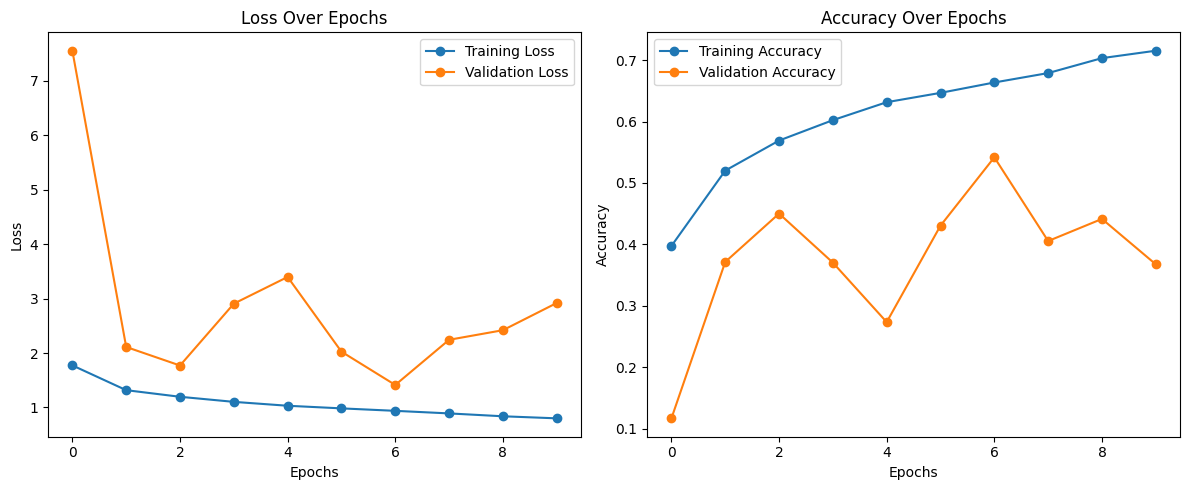

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


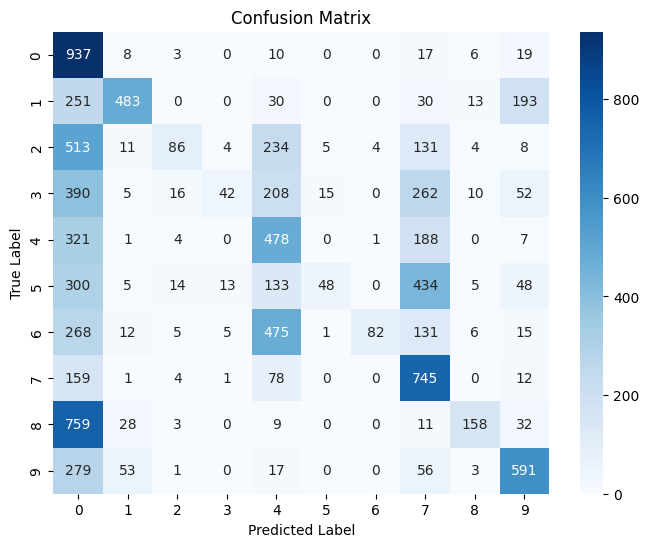

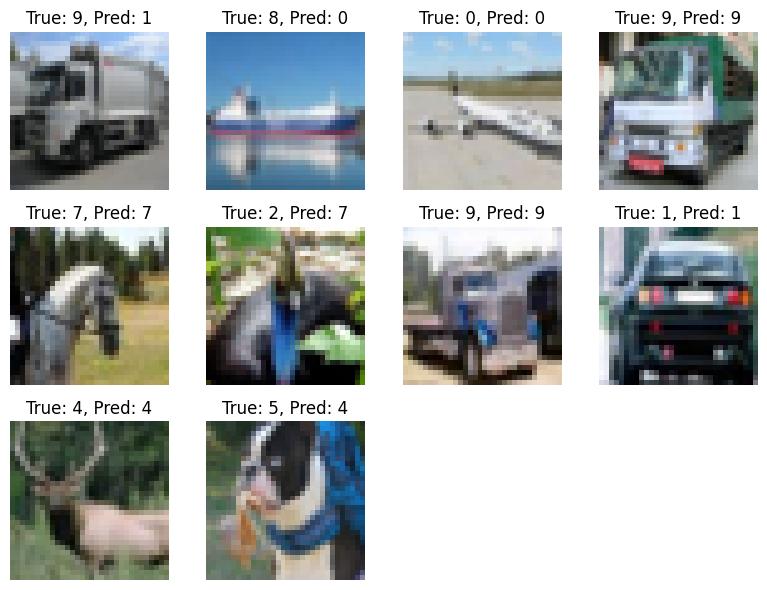

In [53]:
plot_training_results(monitor, x_test, y_test, n_samples=10)